### This example demonstrate application of machine learning methods for forecasting Vertical Total Electron Content (VTEC) in the Earth's ionosphere. VTEC data were extracted for single point in mid-latitude at 10E 40N from the Global Ionosphere Map (GIM) provided by CODE, Bern from https://cddis.nasa.gov/archive/gnss/products/ionex/.
### Input data contain indices and measurements of solar activity and solar-terestrial processes, i.e., solar radio flux F10.7, solar wind speed, Bz index of interplenetary geomagnetic field and Dst (disturbance storm time) index of geomagnetic field, downloaded from OMNIWeb Service from NASA at: https://omniweb.gsfc.nasa.gov/form/dx1.html.
### Learning algorithms tested are Decision Tree and ensemble learning of Random Forest.




### **The notebook is prepared by Randa Natras, Technical University of Munich: randa.natras@tum.de **

# **Load packages and data**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import matplotlib as mpl
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt

import datetime

NumPy showes floating point (real) numbers in the scientific notation. We can turn that off.

In [ ]:
np.set_printoptions(suppress=True)

The data will be loaded into a pandas DataFrame, which are good tools for manipulating and displaying the data. Date-time column is assigned as the index column.

In [ ]:
data_df = pd.read_csv ('ML_VTEC_data.csv', index_col='Date-time')

# **Examining data**

It's good practice to check the data first.

In [ ]:
data_df.head()

,Day of year,Hour of day,F10.7 index (sfu),Solar wind speed (km/s),Bz index (nT),Dst index (nT),VTEC 10E 40N (TECU)
Date-time,,,,,,,
2017-01-01 00:00:00,1,0,70.1,552,-2.5,-13,7.6
2017-01-01 01:00:00,1,1,70.1,556,-3.5,-14,7.2
2017-01-01 02:00:00,1,2,70.1,552,-3.0,-16,6.8
2017-01-01 03:00:00,1,3,70.1,539,0.0,-24,8.2
2017-01-01 04:00:00,1,4,70.1,543,-2.9,-30,8.0


In [ ]:
data_df.columns

Index(['Day of year', 'Hour of day', 'F10.7 index (sfu)',
       'Solar wind speed (km/s)', 'Bz index (nT)', 'Dst index (nT)',
       'VTEC 10E 40N (TECU)'],
      dtype='object')

In [ ]:
data_df.dtypes

Day of year                  int64
Hour of day                  int64
F10.7 index (sfu)          float64
Solar wind speed (km/s)      int64
Bz index (nT)              float64
Dst index (nT)               int64
VTEC 10E 40N (TECU)        float64
dtype: object

In [ ]:
# See the column data types and non-missing values
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Day of year              26280 non-null  int64  
 1   Hour of day              26280 non-null  int64  
 2   F10.7 index (sfu)        26280 non-null  float64
 3   Solar wind speed (km/s)  26280 non-null  int64  
 4   Bz index (nT)            26280 non-null  float64
 5   Dst index (nT)           26280 non-null  int64  
 6   VTEC 10E 40N (TECU)      26280 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.6+ MB


In [ ]:
data_df.describe()

,Day of year,Hour of day,F10.7 index (sfu),Solar wind speed (km/s),Bz index (nT),Dst index (nT),VTEC 10E 40N (TECU)
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,183.000000,11.500000,72.305205,423.439764,1.076541,-6.348059,10.031720
std,105.368033,6.922318,7.611123,172.604188,34.943564,12.927268,3.526582
min,1.000000,0.000000,63.400000,259.000000,-24.200000,-175.000000,2.900000
25%,92.000000,5.750000,68.500000,350.000000,-1.300000,-13.000000,7.100000
50%,183.000000,11.500000,70.000000,396.000000,-0.200000,-4.000000,9.600000
75%,274.000000,17.250000,74.000000,472.000000,1.000000,2.000000,12.500000
max,365.000000,23.000000,185.500000,9999.000000,999.900000,59.000000,32.000000


Now we will create output to forecast VTEC 24 hours in future.

In [ ]:
data_df.reset_index(inplace=True)

In [ ]:
#prepare VTEC output 24h ahead
VTEC_24h=data_df.loc[24::, ['VTEC 10E 40N (TECU)']]

In [ ]:
VTEC_24h.reset_index(inplace=True)
VTEC_24h=VTEC_24h.drop(['index'], axis=1) 

In [ ]:
data_df['VTEC 10E 40N (t+24h)'] = VTEC_24h
data_df = data_df.set_index('Date-time')

In [ ]:
data_df

,Day of year,Hour of day,F10.7 index (sfu),Solar wind speed (km/s),Bz index (nT),Dst index (nT),VTEC 10E 40N (TECU),VTEC 10E 40N (t+24h)
Date-time,,,,,,,,
2017-01-01 00:00:00,1,0,70.1,552.0,-2.5,-13,7.6,7.1
2017-01-01 01:00:00,1,1,70.1,556.0,-3.5,-14,7.2,6.6
2017-01-01 02:00:00,1,2,70.1,552.0,-3.0,-16,6.8,6.9
2017-01-01 03:00:00,1,3,70.1,539.0,0.0,-24,8.2,7.8
2017-01-01 04:00:00,1,4,70.1,543.0,-2.9,-30,8.0,7.3
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,365,19,68.2,310.0,-3.1,-2,6.7,NaN
2019-12-31 20:00:00,365,20,68.2,308.0,-4.0,0,6.2,NaN
2019-12-31 21:00:00,365,21,68.2,308.0,-2.1,-1,6.4,NaN


Check if data contains missing NaN values.

In [ ]:
data_df.isna().sum()

Day of year                 0
Hour of day                 0
F10.7 index (sfu)           0
Solar wind speed (km/s)     0
Bz index (nT)               0
Dst index (nT)              0
VTEC 10E 40N (TECU)         0
VTEC 10E 40N (t+24h)       24
dtype: int64

In [ ]:
#creating output for 24h forecast resulted in NaN values. We will drop NaN now:
data_df=data_df.dropna()

# **Exploratory Data Analysis**

Exploratory Data Analysis is a process of analyzing data to summarize their main characteristics using statistical graphics and other data visualization methods in order to find trends, anomalies, patterns, and relationships within the data. The findings can be used to help us decide which input features to use.

## **Plotting data**

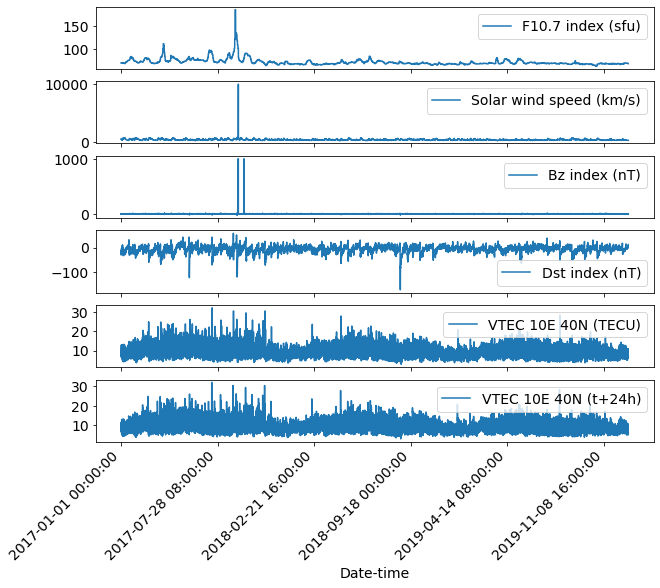

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True)

data_df.plot(ax=axes[0], y='F10.7 index (sfu)', figsize=(10, 8))
data_df.plot(ax=axes[1], y='Solar wind speed (km/s)', figsize=(10, 8))
data_df.plot(ax=axes[2], y='Bz index (nT)', figsize=(10, 8))
data_df.plot(ax=axes[3], y='Dst index (nT)', figsize=(10, 8))
data_df.plot(ax=axes[4], y='VTEC 10E 40N (TECU)', figsize=(10, 8))
data_df.plot(ax=axes[5], y='VTEC 10E 40N (t+24h)', figsize=(10, 8))
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 14})
plt.show()

Plot shows outliers in solar wind speed and Bz index. Values of 999.9 and 9999 usually denotes missing values or instrument failure. We can check how many of these values are contained in our dataset.

In [ ]:
data_df.isin([9999]).sum()

Day of year                0
Hour of day                0
F10.7 index (sfu)          0
Solar wind speed (km/s)    6
Bz index (nT)              0
Dst index (nT)             0
VTEC 10E 40N (TECU)        0
VTEC 10E 40N (t+24h)       0
dtype: int64

In [ ]:
data_df.isin([999.9]).sum()

Day of year                 0
Hour of day                 0
F10.7 index (sfu)           0
Solar wind speed (km/s)     0
Bz index (nT)              32
Dst index (nT)              0
VTEC 10E 40N (TECU)         0
VTEC 10E 40N (t+24h)        0
dtype: int64

In [ ]:
# Replace all 999.9 and 9999 with NaNs to make it easier to work with
data_df.replace(to_replace=999.9, value=np.nan, inplace=True)
data_df.replace(to_replace=9999, value=np.nan, inplace=True)

In [ ]:
data_df.isin([9999]).sum()

Day of year                0
Hour of day                0
F10.7 index (sfu)          0
Solar wind speed (km/s)    0
Bz index (nT)              0
Dst index (nT)             0
VTEC 10E 40N (TECU)        0
VTEC 10E 40N (t+24h)       0
dtype: int64

In [ ]:
data_df.isin([999.9]).sum()

Day of year                0
Hour of day                0
F10.7 index (sfu)          0
Solar wind speed (km/s)    0
Bz index (nT)              0
Dst index (nT)             0
VTEC 10E 40N (TECU)        0
VTEC 10E 40N (t+24h)       0
dtype: int64

Values NaN can be interpolated or dropped. Here we will drop all NaN values.

In [ ]:
data_df = data_df.dropna()

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 8 Text major ticklabel objects>)

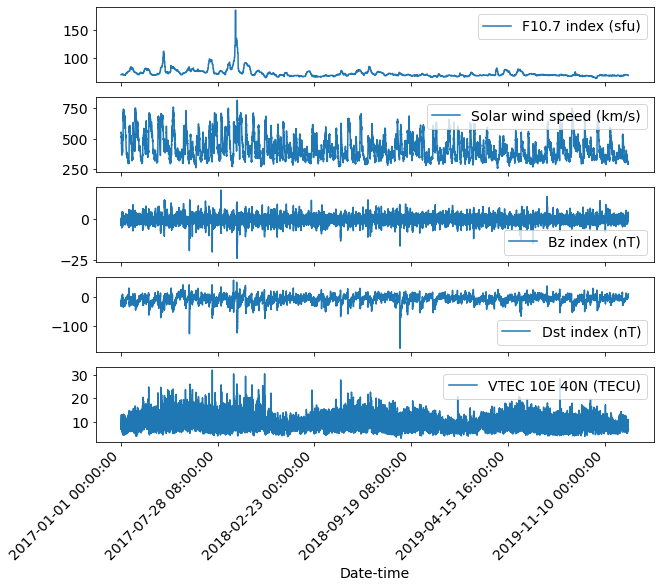

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True)

data_df.plot(ax=axes[0], y='F10.7 index (sfu)', figsize=(10, 8))
data_df.plot(ax=axes[1], y='Solar wind speed (km/s)', figsize=(10, 8))
data_df.plot(ax=axes[2], y='Bz index (nT)', figsize=(10, 8))
data_df.plot(ax=axes[3], y='Dst index (nT)', figsize=(10, 8))
data_df.plot(ax=axes[4], y='VTEC 10E 40N (TECU)', figsize=(10, 8))
plt.xticks(rotation=45, ha='right')

## **Distribution of data**

One important tool for checking our data is data visualization. The goal is to predict the VTEC so a reasonable place to start is examining the distribution of this variable. A histogram is a simple yet effective way to visualize the distribution of a single variable. It is easy to make using seaborn visualization library.

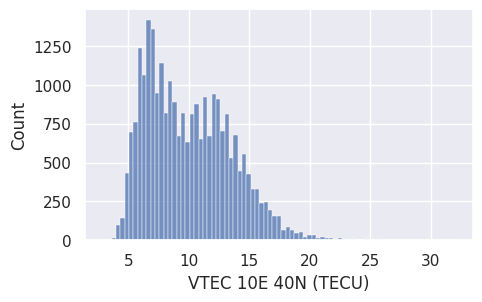

In [ ]:
# Histogram of the VTEC
sns.histplot(data=data_df, x='VTEC 10E 40N (TECU)')
sns.set(rc = {'figure.figsize':(5,3)})

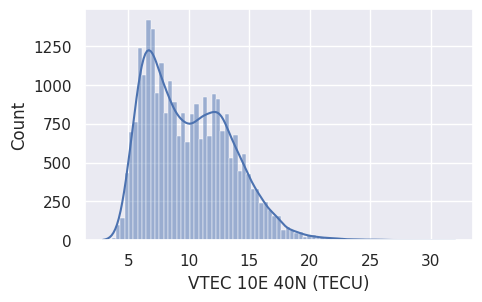

In [ ]:
# Historgram and kernel density estimate 
# complementary information about the shape of the distribution
sns.histplot(data=data_df, x='VTEC 10E 40N (TECU)', kde=True)
sns.set(rc = {'figure.figsize':(5,3)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


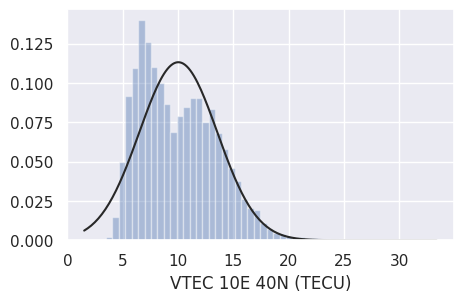

In [ ]:
#Plot the distribution with a histogram and maximum likelihood gaussian distribution fit
from scipy.stats import norm
sns.distplot(data_df['VTEC 10E 40N (TECU)'], fit=norm, kde=False)
sns.set(rc = {'figure.figsize':(5,3)})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb14b85ee90>,
      dtype=object)

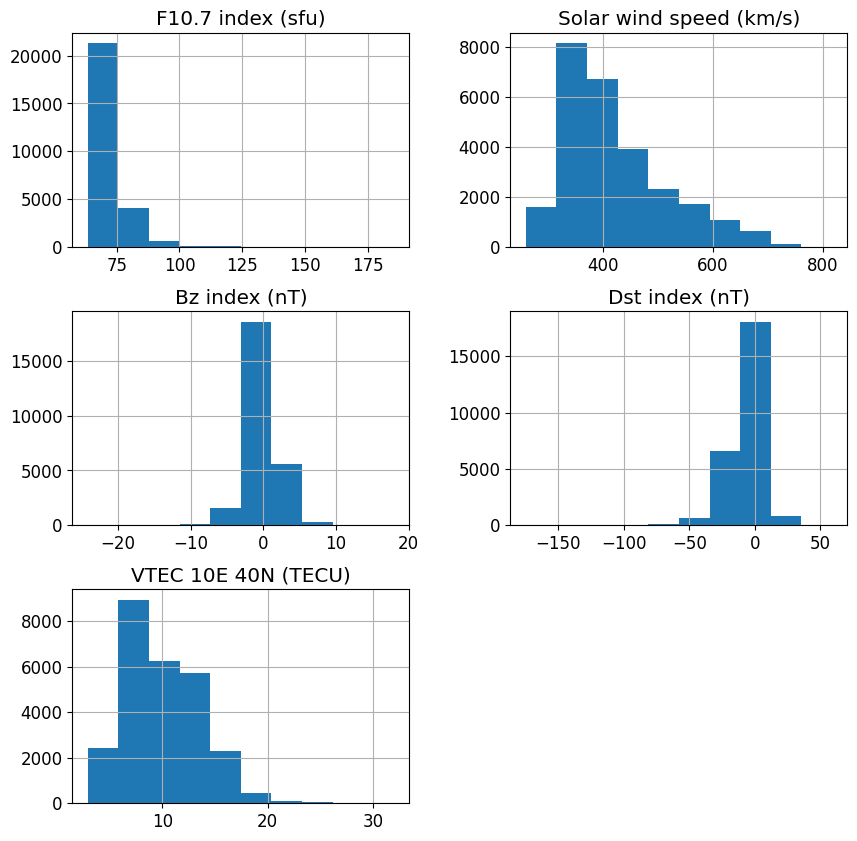

In [ ]:
#histogram of input observation data
plt.style.use('default')
plt.rcParams.update({'font.size': 12})
data_df_2.hist(figsize=(10,10), xlabelsize=12, ylabelsize=12)

A matrix of scatter plots can be use to check how much one variable is affected by another and show the (linear) relationship between two sets of observations.

In [ ]:
plt.style.use('default')
sns.pairplot(data_df)

Output hidden; open in https://colab.research.google.com to view.

## Correlation analysis

In [ ]:
#Correlation table
np.round(data_df.corr(), 2)

,Day of year,Hour of day,F10.7 index (sfu),Solar wind speed (km/s),Bz index (nT),Dst index (nT),VTEC 10E 40N (TECU),VTEC 10E 40N (t+24h)
Day of year,1.00,-0.00,-0.06,-0.03,0.03,0.02,-0.08,-0.08
Hour of day,-0.00,1.00,0.00,0.00,-0.00,-0.01,0.31,0.31
F10.7 index (sfu),-0.06,0.00,1.00,0.17,-0.02,-0.07,0.23,0.23
Solar wind speed (km/s),-0.03,0.00,0.17,1.00,-0.08,-0.59,0.05,-0.04
Bz index (nT),0.03,-0.00,-0.02,-0.08,1.00,0.31,-0.02,0.02
Dst index (nT),0.02,-0.01,-0.07,-0.59,0.31,1.00,-0.03,0.07
VTEC 10E 40N (TECU),-0.08,0.31,0.23,0.05,-0.02,-0.03,1.00,0.87
VTEC 10E 40N (t+24h),-0.08,0.31,0.23,-0.04,0.02,0.07,0.87,1.00


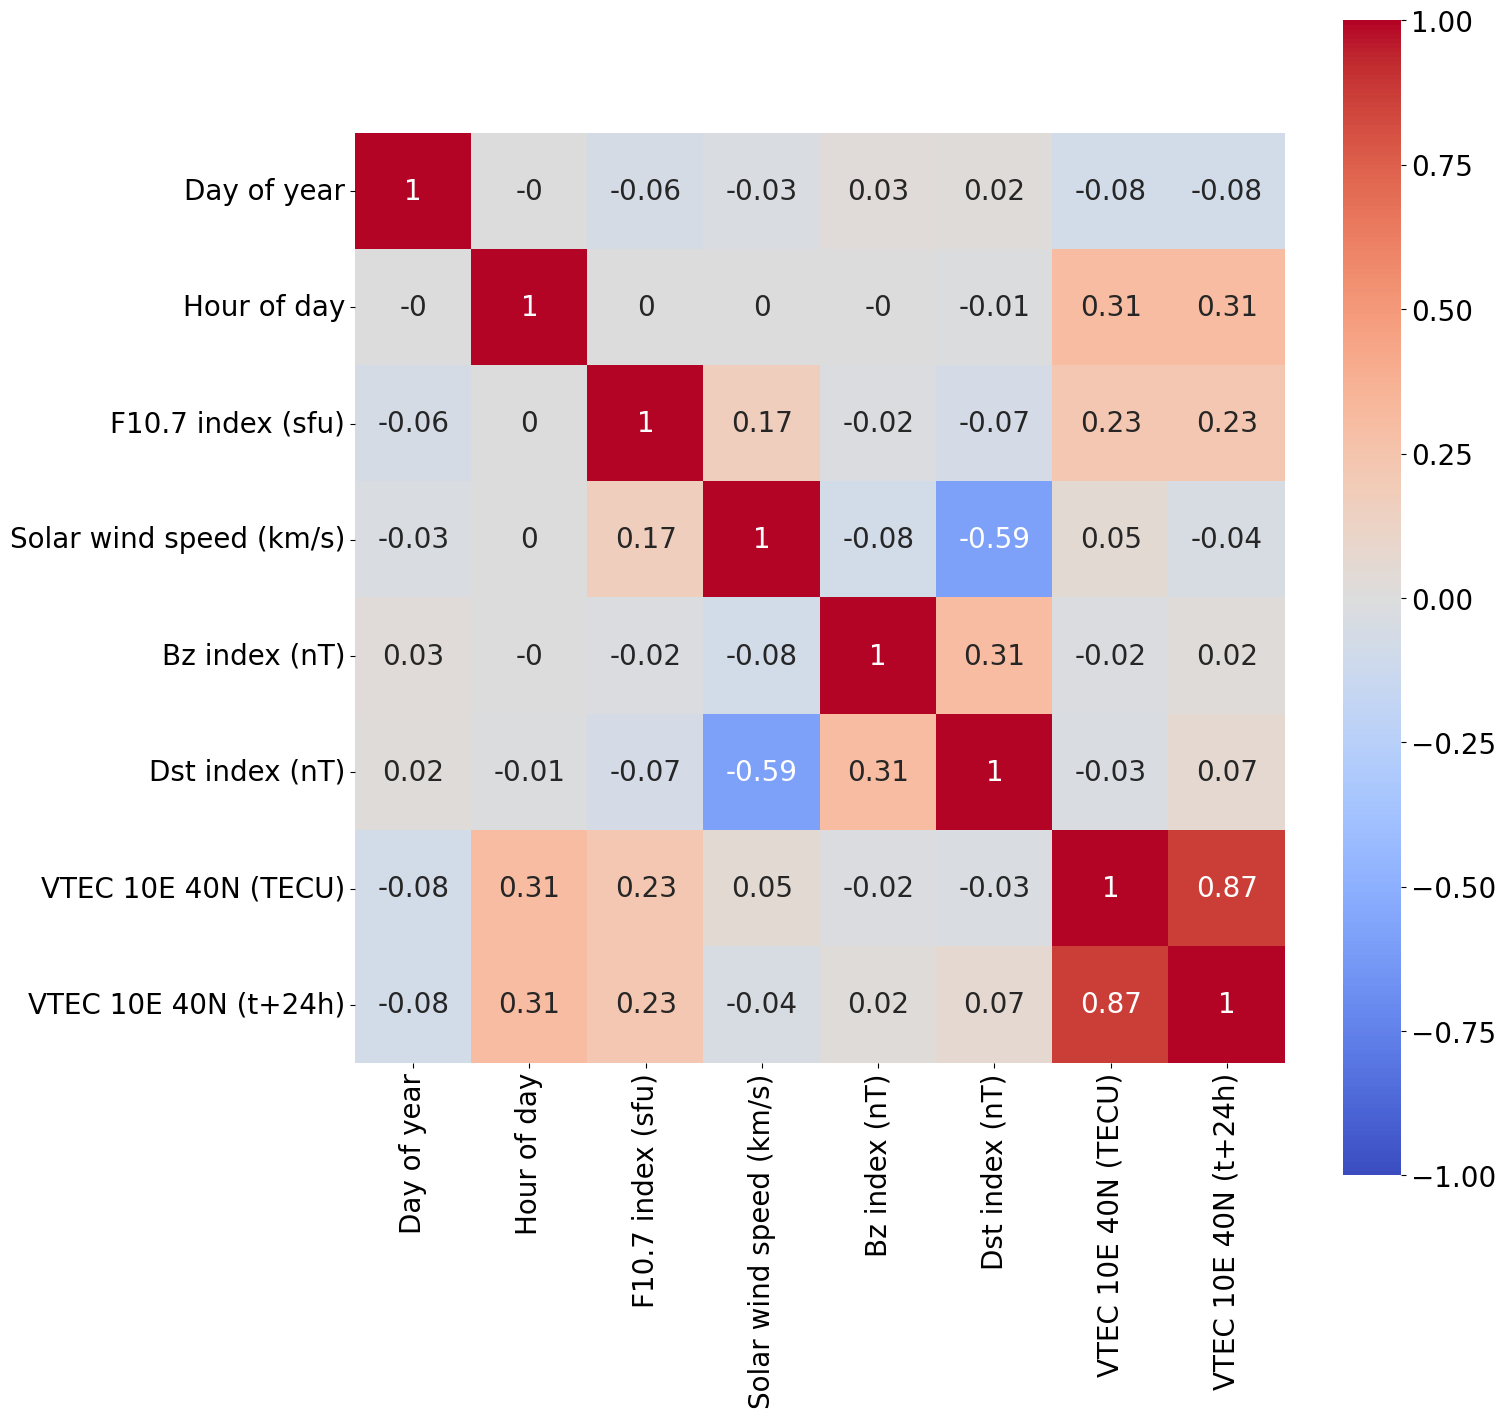

In [ ]:
c = np.round(data_df.corr(), 2)
plt.figure(figsize=(15,15))
sns.heatmap(c, annot=True, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.rcParams.update({'font.size':20})

In [ ]:
# Find all correlations with the output and sort 
correlations =data_df.corr()['VTEC 10E 40N (t+24h)'].sort_values()
correlations

Day of year               -0.084174
Solar wind speed (km/s)   -0.037257
Bz index (nT)              0.015985
Dst index (nT)             0.071715
F10.7 index (sfu)          0.231805
Hour of day                0.306664
VTEC 10E 40N (TECU)        0.866748
VTEC 10E 40N (t+24h)       1.000000
Name: VTEC 10E 40N (t+24h), dtype: float64

# **Preparing the data for training**

Data will be prepared as NumPy arrays that will be used by scikit-learn algorithms. X will be a matrix which has different datapoints in different rows and different input features in different columns. Labels (or targets) y will be a vector consisting of 'VTEC 10E 40N (t+24h)' column.

In [ ]:
X = data_df.drop(['VTEC 10E 40N (t+24h)'], axis=1).to_numpy()
y = data_df ['VTEC 10E 40N (t+24h)'].to_numpy()

In [ ]:
dates = pd.to_datetime(data_df.index) 

In [ ]:
#we will perform testing on for year 2019 (from 1 January to 30 December) which is 8736 data points
#test data need to be excluded from the training data
split_time = 8736
X_train = X [:-split_time]
y_train = y [:-split_time]
time_train = dates [:-split_time]

X_test= X [-split_time:]
y_test = y [-split_time:]
time_test = dates [-split_time:]

In [ ]:
time_train

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Date-time', length=17488, freq=None)

In [ ]:
time_test

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2019-12-30 14:00:00', '2019-12-30 15:00:00',
               '2019-12-30 16:00:00', '2019-12-30 17:00:00',
               '2019-12-30 18:00:00', '2019-12-30 19:00:00',
               '2019-12-30 20:00:00', '2019-12-30 21:00:00',
               '2019-12-30 22:00:00', '2019-12-30 23:00:00'],
              dtype='datetime64[ns]', name='Date-time', length=8736, freq=None)

In [ ]:
y_train.size

17488

In [ ]:
y_test.size

8736

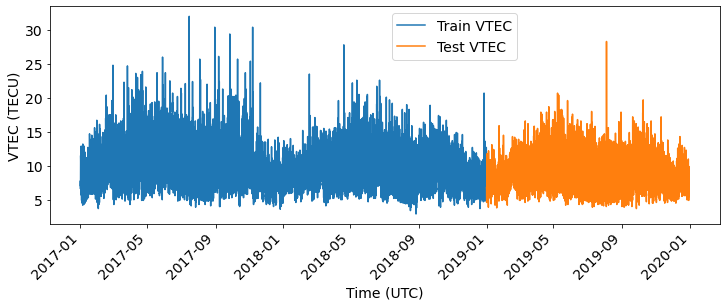

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(time_train, y_train, label='Train VTEC')
ax.plot(time_test, y_test, label='Test VTEC')
plt.ylabel('VTEC (TECU)')
plt.xlabel('Time (UTC)')
plt.legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.xticks(rotation=45, ha='right')
plt.show()
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12,5)

# Model Tuning

## Splitting the data

Data are splitted applying time series cross-validation splitting based on Kfold with 20 splits as in https://www.mdpi.com/2072-4292/14/15/3547.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20) 

## Decision Tree Regressor Tuning

We can use cross_val_score() along with KFold to evaluate the model for different hyperparameters. Here we are going to try different hyperparameter values and choose the ones for which we get the highest model score.

There are multiple hyperparameters such as max_depth, min_samples_split, min_samples_leaf etc. which affect the model performance. More information can be found, for example in https://www.mdpi.com/2072-4292/14/15/3547. Here we are going to tune the model based on 'max_depth'. We will try different values for max_depth values from 1 to 20. Depending on the final 'RMSE' score, we will choose the final value of max_depth.

In [ ]:
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [ ]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

for val in max_depth:
    score = cross_val_score(DecisionTreeRegressor(max_depth= val), X_train, y_train, cv= tscv, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    rmse(score.mean())

For max depth: 1
rmse= 2.37
For max depth: 2
rmse= 1.96
For max depth: 3
rmse= 1.86
For max depth: 4
rmse= 1.84
For max depth: 5
rmse= 1.87
For max depth: 6
rmse= 1.95
For max depth: 7
rmse= 2.06
For max depth: 8
rmse= 2.13
For max depth: 9
rmse= 2.11
For max depth: 10
rmse= 2.24
For max depth: 15
rmse= 2.46
For max depth: 20
rmse= 2.53


## Random Forest Regressor Tuning

There are multiple hyperparameters like n_estimators, max_depth, max_features, min_samples_split etc. which affect the model performance. Here we will tune the 'n_estimators'. We will try different range of values for max_depth, max_features and number of estimators. Depending on the final 'RMSE' score, we will choose the value of these hyperparameters.

In [ ]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 50, None]

for count in max_depth:
    score = cross_val_score(RandomForestRegressor(max_depth = count), X_train, y_train, cv = tscv, scoring="neg_mean_squared_error")
    print(f'For max depth: {count}')
    rmse(score.mean())

For max depth: 1
rmse= 2.32
For max depth: 2
rmse= 1.92
For max depth: 3
rmse= 1.81
For max depth: 4
rmse= 1.76
For max depth: 5
rmse= 1.76
For max depth: 6
rmse= 1.75
For max depth: 7
rmse= 1.75
For max depth: 8
rmse= 1.76
For max depth: 9
rmse= 1.77
For max depth: 10
rmse= 1.77
For max depth: 12
rmse= 1.79
For max depth: 15
rmse= 1.79
For max depth: 20
rmse= 1.80
For max depth: 25
rmse= 1.78
For max depth: 50
rmse= 1.78
For max depth: None
rmse= 1.78


In [ ]:
max_features = [1, 2, 3, 4, 5, 6, 7]

for count in max_features:
    score = cross_val_score(RandomForestRegressor(max_features = count, max_depth = 7), X_train, y_train, cv = tscv, scoring="neg_mean_squared_error")
    print(f'For max_features: {count}')
    rmse(score.mean())

For max_features: 1
rmse= 1.90
For max_features: 2
rmse= 1.70
For max_features: 3
rmse= 1.68
For max_features: 4
rmse= 1.69
For max_features: 5
rmse= 1.72
For max_features: 6
rmse= 1.74
For max_features: 7
rmse= 1.76


In [ ]:
estimators = [10, 50, 100, 200, 300, 400, 500, 1000]

for count in estimators:
    score = cross_val_score(RandomForestRegressor(n_estimators = count, max_features = 3, max_depth = 7), X_train, y_train, cv = tscv, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    rmse(score.mean())

For estimators: 10
rmse= 1.74
For estimators: 50
rmse= 1.70
For estimators: 100
rmse= 1.69
For estimators: 200
rmse= 1.68
For estimators: 300
rmse= 1.68
For estimators: 400
rmse= 1.68
For estimators: 500
rmse= 1.68
For estimators: 1000
rmse= 1.68


# **Decision Tree**

## Model training 

In [ ]:
model_dtree = DecisionTreeRegressor(max_depth=4)

In [ ]:
model_dtree=model_dtree.fit(X_train, y_train)
y_pred_train=model_dtree.predict(X_train)

In [ ]:
print ('Metrics on train data')
print('Root mean square error (RMSE):', round(np.sqrt(mean_squared_error(y_train,y_pred_train)),2))
print("Explain variance score =", round(metrics.explained_variance_score(y_train,y_pred_train), 2)) 
print("R2 score =", round(metrics.r2_score(y_train,y_pred_train), 2))

Metrics on train data
Root mean square error (RMSE): 1.72
Explain variance score = 0.79
R2 score = 0.79


In [ ]:
dtree_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))

## **Visualizing the Decision Tree**

Now, let's visualize our Decision Tree. Let's export our model as a special kind of data, create a visual representation from that, generate a graph and show that graph as an image:

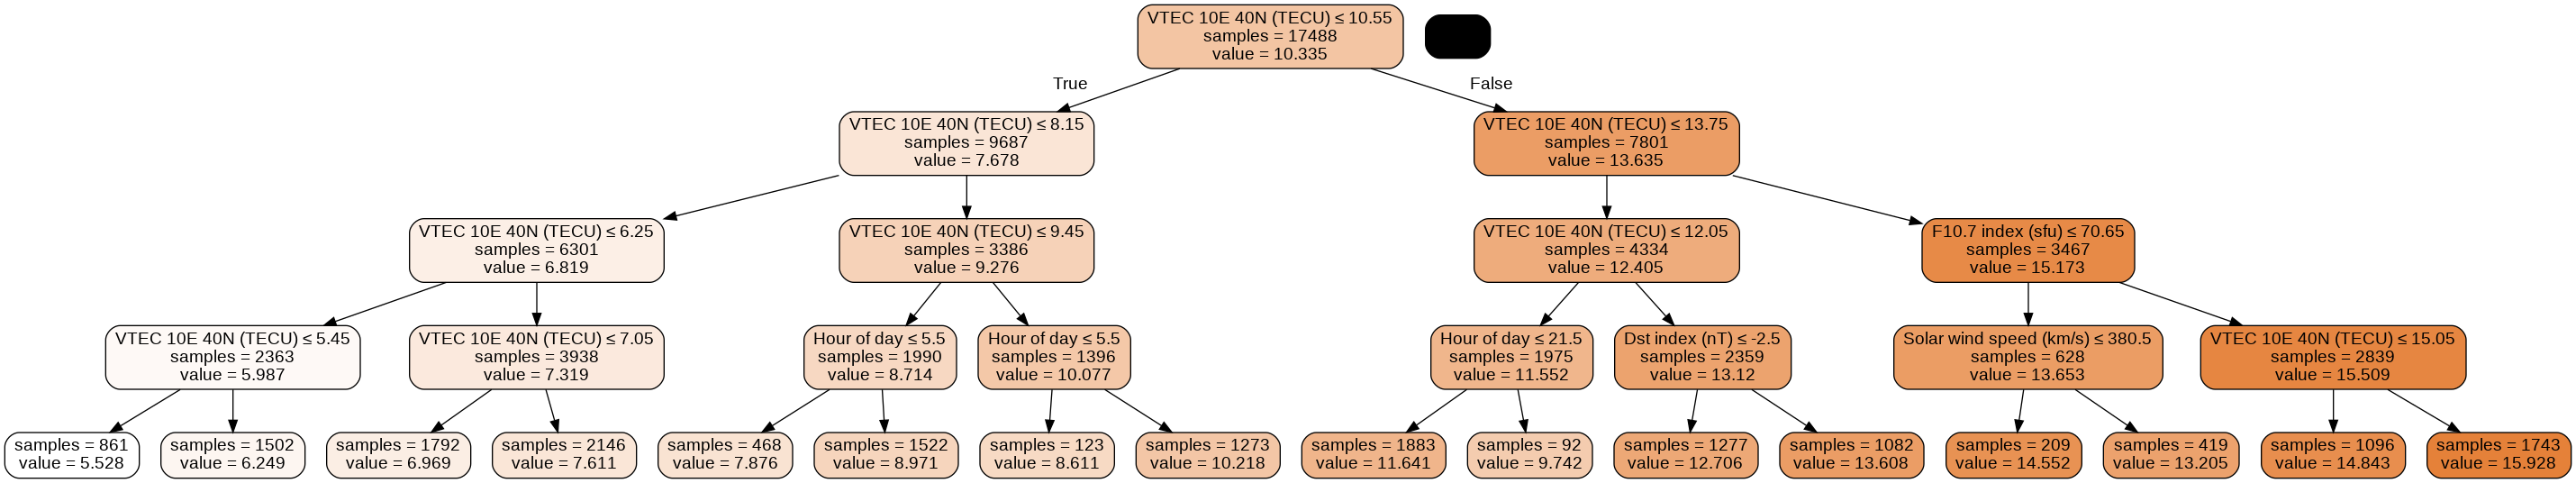

In [ ]:
import pydotplus
import Image
dot_data = 'tree.dot'
export_graphviz(model_dtree, out_file=dot_data,feature_names=data_df.columns[:-1], filled=True, rounded=True, impurity=False, special_characters=True)
graph=pydotplus.graph_from_dot_file(dot_data)
Image(graph.create_png(), unconfined=True)

## **Testing the model**

Finally, let's evaluate our model on the test data to get a final accuracy performance score for our model.

In [ ]:
y_pred_test=model_dtree.predict (X_test)

In [ ]:
print ('Metrics on test data:')
print('Root mean squared error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test)),2))
print("Explain variance score =", round(metrics.explained_variance_score(y_test,y_pred_test), 2)) 
print("R2 score =", round(metrics.r2_score(y_test,y_pred_test), 2))

Metrics on test data:
Root mean squared error (RMSE): 1.42
Explain variance score = 0.77
R2 score = 0.77


In [ ]:
dtree_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))

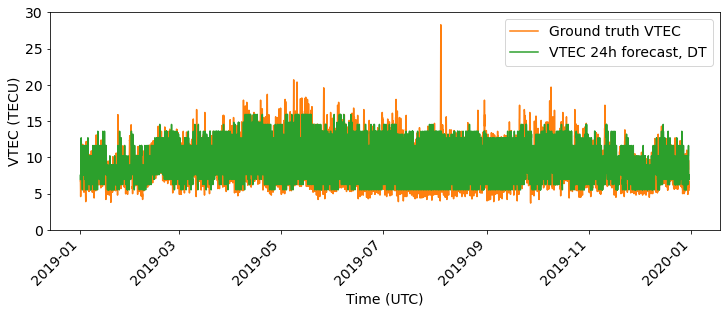

In [ ]:
#plot for year 2019: January - December 2019
plt.plot(time_test, y_test, 'tab:orange', label='Ground truth VTEC')
plt.plot(time_test, y_pred_test, 'tab:green', label='VTEC 24h forecast, DT')
plt.ylabel('VTEC (TECU)')
plt.xlabel('Time (UTC)')
plt.xticks(rotation=45, ha='right')
plt.yticks((np.arange(0.0, 31.0, 5.0)))
plt.legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.show()
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12,4)

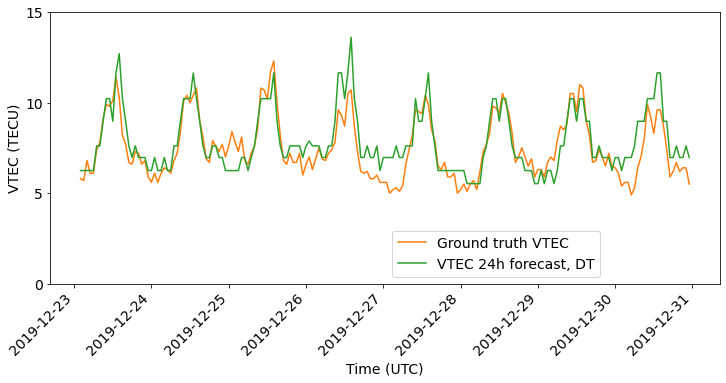

In [ ]:
#plot for 8 days: 23 - 30 December 2019
plt.plot(time_test[-190:], y_test[-190:], 'tab:orange',label='Ground truth VTEC')
plt.plot(time_test[-190:], y_pred_test[-190:], 'tab:green', label='VTEC 24h forecast, DT')
plt.ylabel('VTEC (TECU)')
plt.xlabel('Time (UTC)')
plt.xticks(rotation=45, ha='right')
plt.yticks((np.arange(0.0, 16.0, 5.0)))
plt.legend(loc="best", bbox_to_anchor=(0.5, 0, 0.5, 0.5))
plt.show()
plt.rcParams.update({'font.size': 14})

# **Random Forest**

Let's try to improve the score using an ensemble of decision trees in a form of Random forest. The example below represents Random forest model with hyperparameters that minimize RMSE, which we found previously.

## **Model training**

In [ ]:
model_rfr = RandomForestRegressor(max_features = 3, max_depth = 7, n_estimators = 500)

In [ ]:
model_rfr = model_rfr.fit(X_train, y_train)
y_pred_train_rf = model_rfr .predict(X_train)

In [ ]:
print ('Metrics on train data')
print('Root mean square error (RMSE):', round(np.sqrt(mean_squared_error(y_train,y_pred_train_rf)),2))
print("Explain variance score =", round(metrics.explained_variance_score(y_train,y_pred_train_rf), 2)) 
print("R2 score =", round(metrics.r2_score(y_train,y_pred_train_rf), 2))

Metrics on train data
Root mean square error (RMSE): 1.48
Explain variance score = 0.84
R2 score = 0.84


In [ ]:
rfr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))

## **Feature importance**

Ensembles of decision trees, like Random forest can be used to calculate a feature importance score. It is useful to estimate the relative importance of input features when developing predictive models.

In [ ]:
features = data_df.columns[:-1]

Feature: 0, Score: 0.03649
Feature: 1, Score: 0.23236
Feature: 2, Score: 0.05124
Feature: 3, Score: 0.00887
Feature: 4, Score: 0.00275
Feature: 5, Score: 0.00815
Feature: 6, Score: 0.66014


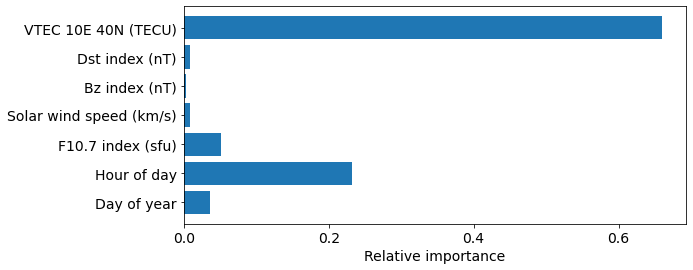

In [ ]:
  importance = model_rfr.feature_importances_
  
  # summarize feature importance
  for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

  # plot feature importance
  plt.barh([x_train for x_train in range(len(importance))], importance, align='center')
  plt.yticks(range(len(features)), features)
  plt.xticks((np.arange(0.0, 0.8, 0.2)))
  plt.rcParams ['figure.figsize'] = [9, 4]
  plt.rcParams.update({'font.size': 14})
  plt.xlabel('Relative importance')
  plt.show()

## **Testing the model**

Finally, let's evaluate our model on the test data to get a final accuracy performance score for our model.

In [ ]:
y_pred_test_rf = model_rfr.predict (X_test)

In [ ]:
print ('Metrics on test data:')
print('Root mean squared error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test_rf)),2))
print("Explain variance score =", round(metrics.explained_variance_score(y_test,y_pred_test_rf), 2)) 
print("R2 score =", round(metrics.r2_score(y_test,y_pred_test_rf), 2))

Metrics on test data:
Root mean squared error (RMSE): 1.3
Explain variance score = 0.81
R2 score = 0.81


In [ ]:
rfr_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_test_rf))

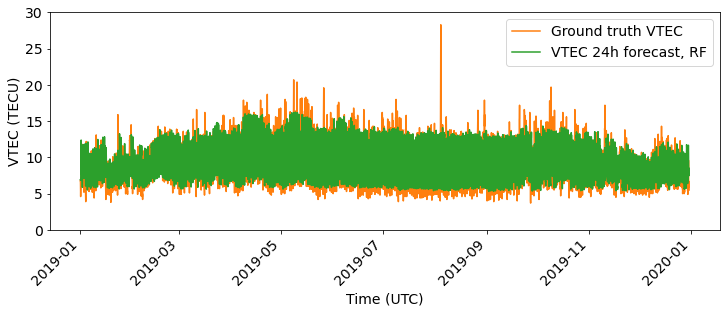

In [ ]:
plt.plot(time_test, y_test, 'tab:orange',label='Ground truth VTEC')
plt.plot(time_test, y_pred_test_rf, 'tab:green', label='VTEC 24h forecast, RF')
plt.ylabel('VTEC (TECU)')
plt.xlabel('Time (UTC)')
plt.yticks((np.arange(0.0, 31.0, 5.0)))
plt.xticks(rotation=45, ha='right')
plt.legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.show()
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12,4)

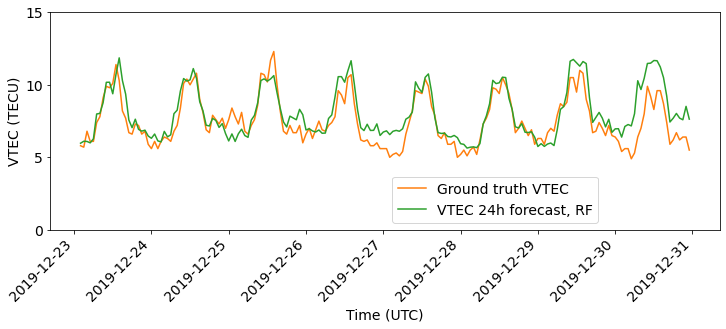

In [ ]:
#forecast for 8 days at the end of December 2019
plt.plot(time_test[-190:], y_test[-190:], 'tab:orange',label='Ground truth VTEC')
plt.plot(time_test[-190:], y_pred_test_rf[-190:], 'tab:green', label='VTEC 24h forecast, RF')
plt.ylabel('VTEC (TECU)')
plt.xlabel('Time (UTC)')
plt.yticks((np.arange(4.0, 13.0, 2.0)))
plt.legend(loc="best", bbox_to_anchor=(0.5, 0, 0.5, 0.5))
plt.xticks(rotation=45, ha='right')
plt.yticks((np.arange(0.0, 16.0, 5.0)))
plt.show()
plt.rcParams.update({'font.size': 14})

# **Comparison: Decision Tree and Random Forest**

We will calculate differences between ground truth VTEC and VTEC forecasts by Decision Tree and Random Forest models. Using the seaborn library, we will then compare histogram plots between two models and see where most of the differences are located.

In [ ]:
diff_dtree = y_test - y_pred_test
diff_rf = y_test - y_pred_test_rf

In [ ]:
diff_rf = y_test - y_pred_test_rf

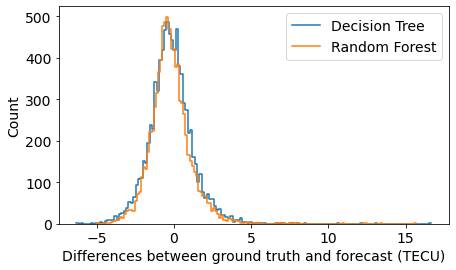

In [ ]:
sns.histplot(diff_dtree, log_scale=False, element="step", fill=False, label='Decision Tree')
sns.histplot(diff_rf, log_scale=False, element="step", fill=False, label='Random Forest')
plt.legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.xlabel('Differences between ground truth and forecast (TECU)')
plt.rcParams ['figure.figsize'] = [7.0, 4.0]

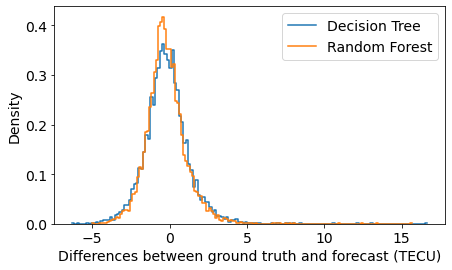

In [ ]:
sns.histplot(diff_dtree, log_scale=False, element="step", fill=False, label='Decision Tree', stat="density")
sns.histplot(diff_rf, log_scale=False, element="step", fill=False, label='Random Forest', stat="density")
plt.legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.xlabel('Differences between ground truth and forecast (TECU)')
plt.rcParams ['figure.figsize'] = [7.0, 4.0]

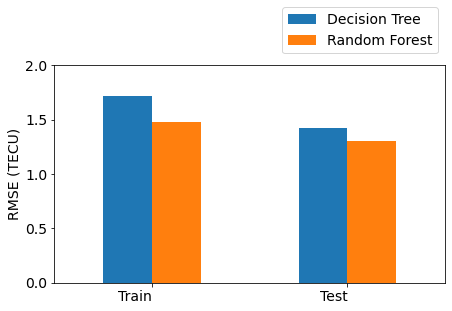

In [ ]:
x = ['Train', 'Test']
y_dt = [dtree_train_rmse, dtree_test_rmse]
y_rf = [rfr_train_rmse, rfr_test_rmse]
df = pd.DataFrame({'Decision Tree': y_dt,
                   'Random Forest': y_rf}, index=x)
ax = df.plot.bar(ylabel='RMSE (TECU)')
plt.xticks(rotation=0, ha='right')
ax.legend(loc="best", bbox_to_anchor=(1, 0.8, 0, 0.5))
ax.set_yticks((np.arange(0.0, 2.1, 0.5)))